# Predicting brain activity with Neural Nets and TensorFlow is easy(-ish)

## Backgroud

I [previously talked about](https://drorcohengithub.github.io/website/decoding/encoding/fmri/2020/07/31/decoding_visual_experience.html) predicting and decoding brain activity as recorded using fMRI. In that post I followed the tried and true approach of (1) extracting some features from the stimulus and (1) fitting a regularised linear regression from the features to brain activity. It works really well.

One of the reasons we use linear regression in these type of "encoding" studies is that there is not much data. For example in that study the training set had only about 7200 samples (which is quite a lot by fMRI community standards). The traditional thinking is that very rich models, such as deep neural nets (NNs) with millions of parameters, will disastrously over-fit in this type of situation, resulting in low performance. However, this traditional thinking may be out of date. 

A [recent paper uploaded to bioarxiv](https://www.biorxiv.org/content/10.1101/2020.09.11.293878v1) generated some discussion in our lab. It is a very thorough study looking at predicting brain activity using deep NNs with many interesting results. Among these results, the authors show that replacing the linear regression with a NN net provides a substantial improvement over linear regression (see also [here]). 

I think is pretty likely that with some effort and a lot of NN know-how an expert can improve on the performance of a linear model. But I figured that avoiding over fitting in this situation is going to be really hard, and that an out of the box implementation would be perform disastrously. So I thought I'd give it a go.

In this post I go through fitting a simple NN, though still with millions of parameters, to predict brain activity. I'll use a vanilla NN paired with the same data I analyzed in my previous post. This way we will have a direct comparison with the linear model. A full notebook to reproduce this is up on my github. 

## Preparations 

We will use the same data from last time. For convenience I put everything you'll need [here]:(https://figshare.com/s/9803543b6736009e7a83).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = "20"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K 

In [5]:
#load the preproc data from before
with np.load("./data.npz") as f:
    print(f.files)
    voxel_test_data = f["voxel_test_data"]
    voxel_train_data = f["voxel_train_data"] 
    ME_features_train_data = f["ME_features_train_data"]
    ME_features_test_data = f["ME_features_test_data"] 
    linear_model_acc = f["linear_model_acc"]

['voxel_test_data', 'voxel_train_data', 'ME_features_train_data', 'ME_features_test_data', 'linear_model_acc']


- **voxel_train_data** this is the brain activity data we will use to train the model
- **voxel_test_data** this is the brain activity data we will use in the final test of the model
- **ME_features_train_data** this is the ME feature data we will use to train the model. The feature vector consists of stacking together four consecutive delays (t-3 to t-6, see the original post for details)
- **ME_features_test_data** this is the ME feature data we will use in the final test of the model
- **linear_model_acc** this is the accuracy data for the linear model. This is calculated as the pearsons correlation between the model predictions and the test data (i.e. voxel_test_data)

I restrict the analysis to the 2000 voxels that were best predicted using the linear model. This is a bit harsh on our NN here because it is possible that the NN improves on voxels that the linear model was poor at predicting, so keep that in mind. 

In [65]:
feature_dim = ME_features_train_data.shape[1]
num_voxels = voxel_train_data.shape[1]

## The network

We first need to decide on the structure of the network. There is now a whole zoo of network architectures and I think it is pretty likely that many of them are superior to the linear model. However, the point here to see how well an "out of the box" NN works. Nothing is more vanilla than a tutorial, so I will use the architecture from the [TensorFlow regression tutorial](https://www.tensorflow.org/tutorials/keras/regression). The architecture has two hidden, densely connected layers with relu activations. We will be fitting a mere 1,812,304 parameters.  

There really is no reason to think that this architecture is suited to our specific problem. But if something like this *does* work, then it may not be so difficult to come up with a NN that is superior to the linear model. 

To the model. 

In [21]:
# repeatable intialization of the weights
initializer = tf.keras.initializers.GlorotNormal(seed=1)

vanilla = tf.keras.Sequential([
    tf.keras.Input(shape=[feature_dim]),
    layers.Dense(64, activation='relu',kernel_initializer=initializer), # set the initial weights
    layers.Dense(64, activation='relu',kernel_initializer=initializer),
    layers.Dense(num_voxels)
])
vanilla.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1678144   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 2000)              130000    
Total params: 1,812,304
Trainable params: 1,812,304
Non-trainable params: 0
_________________________________________________________________


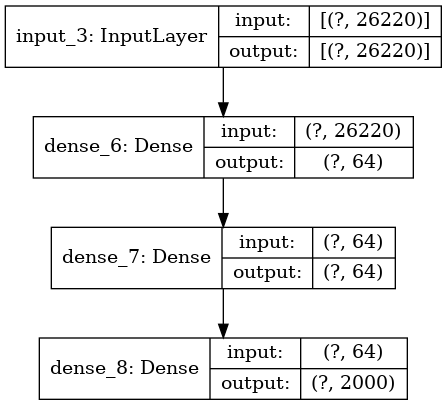

In [22]:
keras.utils.plot_model(vanilla, show_shapes=True,to_file='vanilla.png')

### The optimizer

The next thing is to choose an optimizer for the network. The tutorial used ADAM with a hardwired learning rate, but I went with a simple weight decay approach. Standard stuff, though I did manually tweak it a bit. A more principled approach is to optimize this using cross validation or something but for simplicity I'll keep this as is. 

In [66]:
# initial learning rate
initial_learning_rate = 0.0001
#expontential decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate,
decay_steps=1000,
decay_rate=0.8)

### Compile
Put it all together

In [67]:
# optimize mean squared error
vanilla.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),#
    loss='mean_squared_error',
    metrics=["mean_squared_error"])

### Custom callback to monitor things

As I mentioned, the performance of the model is assess as the correlation between the predicted and actual response (more on this later). This will quickly evaluate our model performance

In [25]:
zs = lambda v,dim=0: (v-v.mean(dim,keepdims=True))/v.std(dim,keepdims=True) 

def respective_correlation(x,y,dim=0):
     
    """
        shape is samps by vars/featurs   
    """  
       
    num_samps = x.shape[dim]
    if not np.array_equal(x.shape, y.shape):
        raise ValueError('x and y must have same shape')

    corrs = (zs(x,dim) * zs(y,dim)).mean(dim) 
    
    return corrs

In [26]:
# We create a custom call back to report on how things are progressing in the end of each epoch
class CustomCallback(Callback):
    
    def __init__(self, val_data): # this gives us access to the validation data (see https://github.com/keras-team/keras/issues/10472 )
        super().__init__()
        self.validation_data = val_data

    def on_epoch_end(self, epoch, logs={}): # on the end of each training epoch get
        
        # the current learning rate
        current_lr = self.model.optimizer._decayed_lr('float32').numpy()
        
        # the correlation between the predicted and actual response
        for val in val_dataset: # calculate correlation on the validation data
            mdl_pred = self.model.predict(val[0])        
            val_corr = np.mean(respective_correlation(mdl_pred, val[1].numpy()))

        # add it to the logs (not sure if this is the correct way to do it but it works)
        logs["val_corr"] = val_corr
        print(f"current lr {current_lr:.2E} corr {val_corr:.03f},\
        MSE {logs['val_mean_squared_error']:.06f}") #, loss {logs['val_loss']:.06f}

## Prepare the training and validation data

I will keep some data aside for validation as we train the model. The key thing to rememeber here is that we are using time series data. This means that the data is not iid. If we just grabbed samples randomly for validation then there is a good chance that dependent samples will be in the training set. For exampel, we may end up with sample at t=n in the val set but t=n-1 in the training set. These are dependent, and in fact likely to be quite similar. In this case performance on the validation test will reflect something of double dipping and probably be much higher than what we get on the final final test set.  

I will very crudely grab three chunks of 200 samples at intervals of 2000, 4000 and 6000 samples. This is completely arbitrary and pretty poor practice. We did much better on the ridge regression in the previous post, but I think it is good enough for illustration. Note that we might have a bit of leakage (since the samples around these chunks are still in the training set), but I think it is not too much of a worry. 

In [27]:
all_data_inds = np.arange(ME_features_train_data.shape[0])
#keep the first, take three, chunk_len samples long chunks for validation 
chunk_len = 200
chunk_starts = np.array([2,4,6])*1000
chunk_ends = chunk_starts+chunk_len
val_inds = np.concatenate([np.arange(strt,stp) for strt,stp in zip(chunk_starts,chunk_ends)])
trn_inds = np.delete(all_data_inds,val_inds)

TensorFlow likes its data in a particular way. This is *really* irritating to me.

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((ME_features_train_data[trn_inds,:], voxel_train_data[trn_inds,:]))
# organized in batches ofo 32 to update the gradients (I think this is default)
train_dataset = train_dataset.batch(32)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((ME_features_train_data[val_inds,:], voxel_train_data[val_inds,:]))

#For the validation I compute the correlation across the entire val data, i.e. one batch
val_dataset = val_dataset.batch(len(chunk_ends))

## Fitting

In [29]:
callback = CustomCallback(val_dataset) # initialize the callback
history = vanilla.fit(train_dataset,callbacks=[callback],
    epochs=20,
    # suppress logging
    verbose=0,
    validation_data=val_dataset)

current lr 9.55E-05 corr 0.087,        MSE 0.918076
current lr 9.13E-05 corr 0.167,        MSE 0.888940
current lr 8.72E-05 corr 0.145,        MSE 0.886320
current lr 8.34E-05 corr 0.206,        MSE 0.883231
current lr 7.96E-05 corr 0.214,        MSE 0.881231
current lr 7.61E-05 corr 0.223,        MSE 0.880562
current lr 7.27E-05 corr 0.226,        MSE 0.881586
current lr 6.95E-05 corr 0.226,        MSE 0.885388
current lr 6.64E-05 corr 0.224,        MSE 0.887500
current lr 6.34E-05 corr 0.210,        MSE 0.892846
current lr 6.06E-05 corr 0.212,        MSE 0.905042
current lr 5.79E-05 corr 0.221,        MSE 0.905674
current lr 5.53E-05 corr 0.241,        MSE 0.893717
current lr 5.29E-05 corr 0.240,        MSE 0.896476
current lr 5.05E-05 corr 0.243,        MSE 0.891423
current lr 4.83E-05 corr 0.240,        MSE 0.893187
current lr 4.61E-05 corr 0.239,        MSE 0.895599
current lr 4.41E-05 corr 0.243,        MSE 0.899942
current lr 4.21E-05 corr 0.243,        MSE 0.902120
current lr 4

### Plot the results 

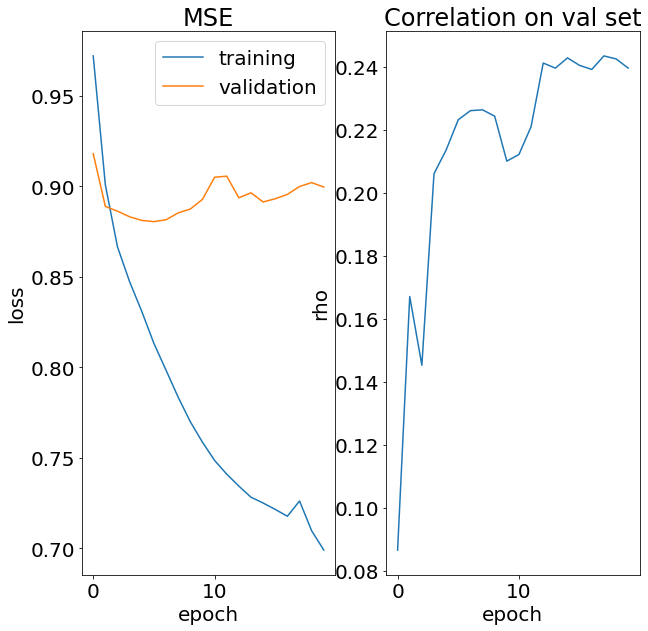

In [30]:
f,a = plt.subplots(1,2,figsize=(10,10))
a[0].plot(history.history['loss'])
a[0].plot(history.history['val_loss'])
a[0].set_xlabel("epoch")
a[0].set_ylabel("loss")
a[0].legend(["training", "validation"])
a[0].set_title("MSE")

a[1].plot(history.history['val_corr'])
a[1].set_xlabel("epoch")
a[1].set_ylabel("rho")
# a[1].legend(["validation"])
a[1].set_title("Correlation on val set")
plt.savefig("./Vanilla_fitting_results.png")

Pretty clear from above that the MSE continues to improve on the training set (blue) but validation performance is pretty much saturated after 1-2 epochs (orange). We're over-fitting. A similar thing for the correlation. It improves a bit in the start but not too much happening after that. You are probably thinking that it is odd to fit using MSE as the loss and then use the correlation as the metric. You are right, but this is pretty common in encoding studies. The reason is that we usually use regularization, and this tends to reduce the norm of the prediction, producing pretty average MSE. However, the correlation between the predicated and actual response can still be high, indicating that the model has replicated much of the temporal structure. So we use correlation but fit based on the MSE. Of course we could write a custom fit using pearson corr as the loss but that is a bit more advanced (I have actually done this and it works pretty well, but that's for another time).

## Compare with ridge

Let's compare our results with the linear model. Based on our over-fitting above, I am expecting a complete disaster

In [31]:
# Our nn predictions
preds = vanilla.predict(ME_features_test_data)
NN_corrs= respective_correlation(preds,voxel_test_data)

# lets also get a null prediction to get an idea of the chance level. 
np.random.seed(1)
permuted_input = np.random.permutation(ME_features_test_data.flatten()).reshape(ME_features_test_data.shape)
permuted_preds = vanilla.predict(permuted_input)
NN_corrs_null= respective_correlation(voxel_test_data,permuted_preds)
top_null = np.percentile(NN_corrs_null,99.5) # treat the top 0.5% voxel as chance level

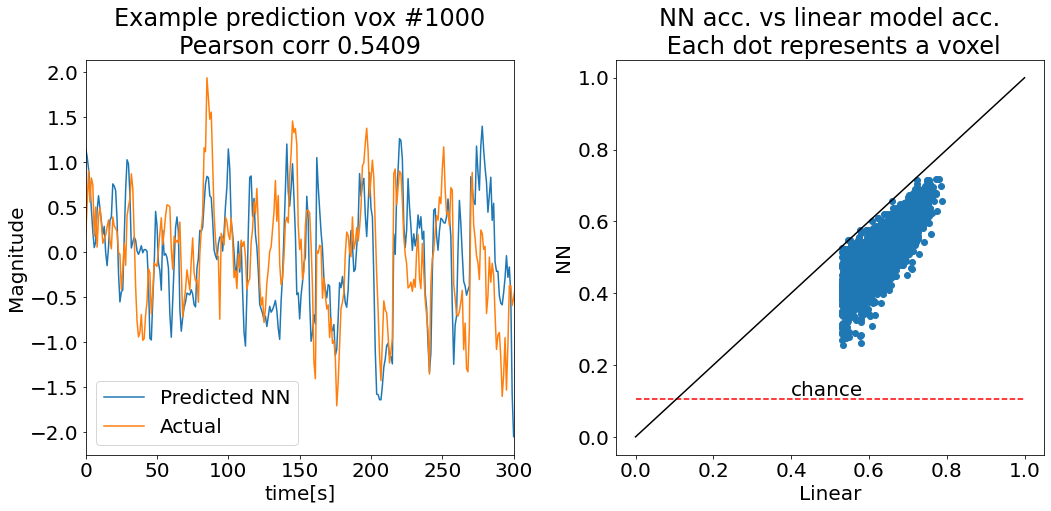

In [41]:
f,a = plt.subplots(1,2,figsize=(15,7.5))
# lets look at the prediction for one voxel,
try_vox = 1000
try_vox_pred = preds[:,try_vox]
try_vox_actual = voxel_test_data[:,try_vox]
a[0].plot(try_vox_pred)
a[0].plot(try_vox_actual)
a[0].set_title(f"Example prediction vox #{try_vox}\n\
Pearson corr {respective_correlation(try_vox_pred,try_vox_actual):.04f}")
a[0].set_xlim([0,300]) # hard to see if this is too long
a[0].set_xlabel("time[s]")
a[0].set_ylabel("Magnitude")
a[0].legend(["Predicted NN","Actual"])

a[1].scatter(linear_model_acc,NN_corrs)
a[1].plot([0,1],[0,1],c="k")
a[1].set_title("NN acc. vs linear model acc.\n Each dot represents a voxel")
# plt.vlines(top_null,*[0,top_null])
a[1].hlines(top_null,*[0,1],color="red",linestyle="--")
a[1].set_xlabel("Linear model")
a[1].set_ylabel("NN model")
plt.text(0.4,top_null+0.01,"chance")
plt.tight_layout()
plt.savefig("./Vanilla_vs_ridge.png")

Well to my great surprise, our vanilla NN, with its millions of parameters trained on just thousands of samples, unquestionably works. Of course our linear solution is far superior but that involved some optimization.

## A tinny bit of optimization 

Let's try to improve a bit with regularization. We will add a couple of dropout layers and also some L2 regularization. We will search through run a a grid and pick the combination with the best accuracy on the validation test.

In [68]:
HP_DROPOUT1 = np.linspace(0,0.8,5) # just 5 steps
HP_DROPOUT2 = HP_DROPOUT1.copy()
HP_L2_1 = np.linspace(0,.01,5)
HP_L2_2 = HP_L2_1.copy()

In [48]:
# a wrapper for constructing the network and fitting
def train_test_model(hparams):
    
    tmp = tf.keras.Sequential([
        tf.keras.Input(shape=[feature_dim]),
        layers.Dropout(hparams["HP_DROPOUT1"]),
        layers.Dense(64, activation='relu',kernel_initializer=initializer
                     ,kernel_regularizer=tf.keras.regularizers.l2(hparams["HP_L2_1"])),
        layers.Dropout(hparams["HP_DROPOUT2"]),
        layers.Dense(64, activation='relu',kernel_initializer=initializer,
                     kernel_regularizer=tf.keras.regularizers.l2(hparams["HP_L2_2"])),
        layers.Dense(num_voxels)
    ])
    
  # optimize mean squared error
    tmp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),#
    loss='mean_squared_error',
    metrics=["mean_squared_error"]
    )

    callback = CustomCallback(val_dataset) # initialize the callback
    history = tmp.fit(train_dataset,callbacks=[callback],
        epochs=5,
        # suppress logging
        verbose=0,
        validation_data=val_dataset
                         )
        
    return history.history["val_corr"][-1]

In [49]:
# well I admit these loops took loner than I thought (~4 hours on my CPU only version of tf) so you may want to dial it down a touch
opt_results = []
for dropout_rate1 in HP_DROPOUT1:
    for dropout_rate2 in HP_DROPOUT2:
        for l2_1 in HP_L2_1:
            for l2_2 in HP_L2_2:
                hparams = {
                    'HP_DROPOUT1': dropout_rate1,
                    'HP_DROPOUT2': dropout_rate2,
                    'HP_L2_1': l2_1,
                    'HP_L2_2': l2_2,
                }
                
                print(hparams)
                this_res = train_test_model(hparams)
                opt_results.append([hparams,this_res])
              

{'HP_DROPOUT1': 0.0, 'HP_DROPOUT2': 0.0, 'HP_L2_1': 0.0, 'HP_L2_2': 0.0}
current lr 9.55E-05 corr 0.069,        MSE 0.916014
current lr 9.13E-05 corr 0.144,        MSE 0.889414
current lr 8.72E-05 corr 0.163,        MSE 0.888818
current lr 8.34E-05 corr 0.180,        MSE 0.886987
current lr 7.96E-05 corr 0.208,        MSE 0.880918
{'HP_DROPOUT1': 0.0, 'HP_DROPOUT2': 0.0, 'HP_L2_1': 0.0, 'HP_L2_2': 0.0025}
current lr 9.55E-05 corr 0.065,        MSE 0.913313
current lr 9.13E-05 corr 0.166,        MSE 0.888468
current lr 8.72E-05 corr 0.198,        MSE 0.886592
current lr 8.34E-05 corr 0.192,        MSE 0.886262
current lr 7.96E-05 corr 0.202,        MSE 0.884602
{'HP_DROPOUT1': 0.0, 'HP_DROPOUT2': 0.0, 'HP_L2_1': 0.0, 'HP_L2_2': 0.005}
current lr 9.55E-05 corr 0.069,        MSE 0.910814
current lr 9.13E-05 corr 0.166,        MSE 0.885564
current lr 8.72E-05 corr 0.199,        MSE 0.885114
current lr 8.34E-05 corr 0.217,        MSE 0.882332
current lr 7.96E-05 corr 0.213,        MSE 0.884

KeyboardInterrupt: 

Get the best performing params

In [50]:
opt_params,opt_corr = zip(*opt_results)#
opt_corr = np.array(opt_corr)
argsortres = np.argsort(opt_corr)
print(opt_corr[argsortres[-1]])
top_params = opt_params[argsortres[-1]]
print(top_params)

0.2179307
{'HP_DROPOUT1': 0.0, 'HP_DROPOUT2': 0.0, 'HP_L2_1': 0.0, 'HP_L2_2': 0.01}


Fit the entire training set with the optimized params
Btw, these were the values I got
{'HP_DROPOUT1': 0.275, 'HP_DROPOUT2': 0.275, 'HP_L2_1': 0.007750000000000001, 'HP_L2_2': 0.007750000000000001}

In [69]:
top_params = {'HP_DROPOUT1': 0.275, 'HP_DROPOUT2': 0.275, 'HP_L2_1': 0.007750000000000001, 'HP_L2_2': 0.007750000000000001}

In [52]:
vanilla_opt = tf.keras.Sequential([
        tf.keras.Input(shape=[feature_dim]),
        layers.Dropout(top_params["HP_DROPOUT1"]),
        layers.Dense(64, activation='relu',kernel_initializer=initializer
                     ,kernel_regularizer=tf.keras.regularizers.l2(top_params["HP_L2_1"])),
        layers.Dropout(top_params["HP_DROPOUT2"]),
        layers.Dense(64, activation='relu',kernel_initializer=initializer,
                     kernel_regularizer=tf.keras.regularizers.l2(top_params["HP_L2_2"])),
        layers.Dense(num_voxels)
    ])
    
# optimize mean squared error
vanilla_opt.compile(
optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),#
loss='mean_squared_error',
metrics=["mean_squared_error"]
)

vanilla_opt_history = vanilla_opt.fit(ME_features_train_data,voxel_train_data,
    epochs=100,
    verbose=1,# just to see how things are progressing
    validation_data=0
                     )

Epoch 1/100
223/223 [==============================] - 2s 8ms/step - loss: 1.9031 - mean_squared_error: 0.9528
Epoch 2/100
223/223 [==============================] - 2s 8ms/step - loss: 1.3411 - mean_squared_error: 0.8756
Epoch 3/100
223/223 [==============================] - 2s 9ms/step - loss: 1.1746 - mean_squared_error: 0.8508
Epoch 4/100
223/223 [==============================] - 2s 8ms/step - loss: 1.0852 - mean_squared_error: 0.8332
Epoch 5/100
223/223 [==============================] - 2s 9ms/step - loss: 1.0263 - mean_squared_error: 0.8207
Epoch 6/100
223/223 [==============================] - 2s 8ms/step - loss: 0.9819 - mean_squared_error: 0.8096
Epoch 7/100
223/223 [==============================] - 2s 8ms/step - loss: 0.9498 - mean_squared_error: 0.8019
Epoch 8/100
223/223 [==============================] - 2s 8ms/step - loss: 0.9230 - mean_squared_error: 0.7936
Epoch 9/100
223/223 [==============================] - 2s 8ms/step - loss: 0.9030 - mean_squared_error: 0.7880
E

In [53]:
# Our optimized predictions
preds = vanilla_opt.predict(ME_features_test_data)
NN_corrs_opt= respective_correlation(preds,voxel_test_data)

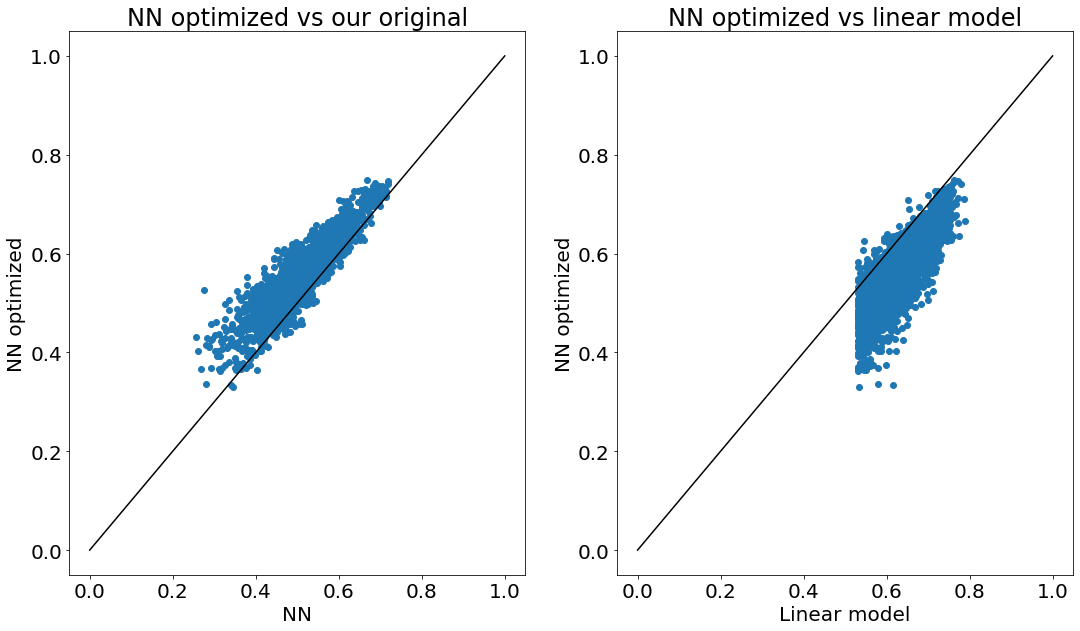

In [71]:
f,a = plt.subplots(1,2,figsize=(18,10))
a[0].scatter(NN_corrs,NN_corrs_opt)
a[0].plot([0,1],[0,1],c="k")
a[0].set_xlabel("NN")
a[0].set_ylabel("NN optimized")
a[0].set_title("NN optimized vs our original")


a[1].set_title("NN optimized vs linear model")
a[1].plot([0,1],[0,1],c="k")
a[1].set_xlabel("Linear model")
a[1].set_ylabel("NN optimized")
a[1].scatter(linear_model_acc,NN_corrs_opt)
plt.savefig("./optimzedNN_vs_ridge")

Clearly the optimization improves on our original attempt, but we are still doing worse than the linear model in most voxels

# Final thoughts

It turns out that it is possible to train a vanilla neural network with millions of parameters to predict BOLD activity using just thousands of training samples, and yet do a *reasonable* job. We performed far better than chance. In our case we cannot beat the linear model, but there are some things to keep in mind here. First, our NN architecture is completely arbitrary and almost certainly not ideal for this type of task. Second, we chose the best voxels according to the linear model, so the comparison is a bit skewed in its favor. Third, our linear model is *not* vanilla, in the sense that it sits at the end of a pipeline designed to make it work (that is to say that there is a long history of fitting linear models that I drew on to build it, much less so for NNs). Lastly, in the linear approach we optimized the regularization for each voxel separately, and then fit each voxel separately. In that sense, our linear model actually has 26220x2000+2000 = 52,442,000 (feature dimXnum voxels + num hyper params) parameters, which is much *more* than our NN, which only had 1,812,304 parameters. In the NN here we fitted all 2000 *simultaneously*. So there is a qualitative difference here that deserves a bit more scrutiny. All in all, I am pretty confident that if these differences were addressed we could match and improve on the linear model.

The point here, however, was to see how difficult it would be to fit a NN with millions of parameters to a typical encoding data set, which usually only has thousands of samples per voxel. It turns out that even an "out of the box" vanilla implementation works pretty well. One advantage of the TensorFlow setup is that once the basic fitting code is in place, it is very easy to try different variations. Adding and dropping layers, trying different activations and regularizations is a breeze. Tip of the hat to the NN community for developing these unbelievable tools. I think in the future I will run something like this along my standard workflow just to see what it looks like. Maybe in time it will become my go-to. Who knows. 

At the start of the post I said that *one* of the reasons we don't use NNs is that fitting them is difficult. Well, as we see here, that argument may not be a very good one. But there are other reasons to use linear models. For example, they are easy to handle and well understood. Most importantly, they are transparent and easy to interpret. This is critical in neuroscience where we don't just want to predict, we want to understand.   